In [1]:
import numpy as np
import scipy.fftpack
import librosa
import mygrad
from mygrad import Tensor
import matplotlib.pyplot as plt
from mygrad.nnet.layers import dense
from mygrad.nnet.losses import multiclass_hinge
from microphone import record_audio
%matplotlib notebook

fs = 44100

# Need 250ms intervals. Since, 44100Hz = 44100 samples/s, (44100/4) cycles/(250ms). Need 44100/4 = 11025 samples.

def file_to_array(file_path):
    """
    It transforms a song into a np array.

    :param
        file_path[String]:
            A file path to the song

    :return:
        samples[np.array]:
            This is an array of the values of the song at the file path at a sampling rate of 44100 Hz.
    """
    samples, fs = librosa.load(file_path, sr=44100, mono=True)
    return samples


def mic_to_numpy_array(time):
    """
    It transforms a mic input into an np array.

    :param
        time[float]:
            The time it needs to record

    :return:
        mic[np.array]:
            This is an array of the values of the song that was recorded at a sampling rate of 44100 Hz.

    """
    mic_input, fs = record_audio(time)
    mic = []
    for i in mic_input:
        mic.append(np.fromstring(i, dtype=np.int16))
    mic = np.hstack(mic)
    return mic

def fft(song_arr):
	"""
	This fast fourier transforms a song array.

	:param
		song_arr[np.array]:
			This is the array that represents the song. 

	:return:
		f[np.array]:
			This is the array of coefficients of the fft. 

	"""

	return np.fft.rfft(song_arr)

def get_freqs(song_arr):
    dft = np.fft.rfft(song_arr)
    times = np.arange(len(song_arr))
    times = times / 44100
    return np.arange(len(dft)) / times[-1]

def mel_scale(fft_arr):
	"""
	This scales the frequencies from hertz into mels.

	:param
		fft_arr[np.array]:
			This is the array of coefficients of an fft. (Check this).

	:return:
		mels[np.array]:
			This is an array that transformed the fft from Hertz into Mels. 

	"""
	return 2595*np.log10(1 + fft_arr/700)

def dct(mel_arr):
	"""
	This does the dct of the 
	"""
	return scipy.fftpack.dct(mel_arr, n=12)

def compute_accuracy(model_out, labels):
    """ Computes the mean accuracy, given predictions and true-labels.
        
        Parameters
        ----------
        model_out : numpy.ndarray, shape=(N, K)
            The predicted class-scores
        labels : numpy.ndarray, shape=(N, K)
            The one-hot encoded labels for the data.
        
        Returns
        -------
        float
            The mean classification accuracy of the N samples."""
    return np.mean(np.argmax(model_out, axis=1) == np.argmax(labels, axis=1))

def sgd(param, rate):
    """ Performs a gradient-descent update on the parameter.
    
        Parameters
        ----------
        param : mygrad.Tensor
            The parameter to be updated.
        
        rate : float
            The step size used in the update"""
    param.data -= rate*param.grad
    return None

def dense_NN(W, b, xtrain, ytrain):
    """
    Does a dense Neural Network on xtrain and updates W and b.

    :Returns:
        (W, b)(tuple of training parameters):
            The W and b are the same as inputted but changed. 
    """
    acc = []
    for i in range(1000):
        o = dense(xtrain, W) + b
        
        loss = multiclass_hinge(o, y)
        
        loss.backward()
        
        sgd(W, 0.1)
        sgd(b, 0.1)
        
        loss.null_gradients()
        acc.append(compute_accuracy(o.data, ytrain))

    return (W, b, acc)

def to_MFCC(song_arr):
    f = fft(song_arr)
    a = dct(f)
    return np.abs(a)

In [13]:
c = mic_to_numpy_array(5)
mel = mel_scale(get_freqs(c))
a = to_MFCC(c)
print(a, len(a))

Using input device 'Microphone Array (Realtek High'
Recording ended
[ 4873.57940956  3888.62318949  3359.58364851  1682.247879    1439.29833209
  1562.59535386  1695.12172924  3116.71504478  4298.84365846  3518.66107588
  2560.92079056  2438.48743954] 12


In [4]:
MFCCs = np.zeros((10,12))

In [5]:
song_paths = [r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Classical\Beethoven's 5th Symphony.mp3",
             r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Jazz\Chet Baker - Almost blue.mp3",
             r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Pop\Imagine Dragons - Radioactive.mp3",
             r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Rap\Jay-Z _ Kanye West - Nias In Paris (Explicit).mp3",
             r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Rock\Guns N' Roses - Patience.mp3",
             r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Classical\Air - Johann Sebastian Bach.mp3",
             r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Jazz\SING, SING, SING BY BENNY GOODMAN.mp3",
             r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Pop\Stevie Wonder - Sir Duke.mp3",
             r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Rap\Lil Wayne - God Bless Amerika.mp3",
             r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining\Rock\The Black Keys - Everlasting Light (Vinyl).mp3"]

for i in range(len(song_paths)):
    a = file_to_array(song_paths[i])
    b = to_MFCC(a)
    for j in range(12):
        MFCCs[i,j] = b[j]
    del a
    del b

In [6]:
ytrain = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1]])

In [7]:
y = np.where(ytrain == 1)[1]
a = Tensor(np.random.randn(12, 5))
c = Tensor(np.zeros((5,), dtype=a.dtype))
W, b, acc = dense_NN(a, c, MFCCs, ytrain)
acc[-1]

0.59999999999999998

<IPython.core.display.Javascript object>


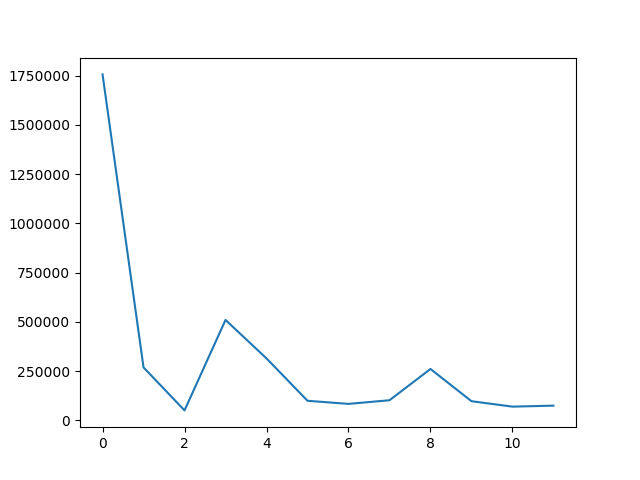

<IPython.core.display.Javascript object>


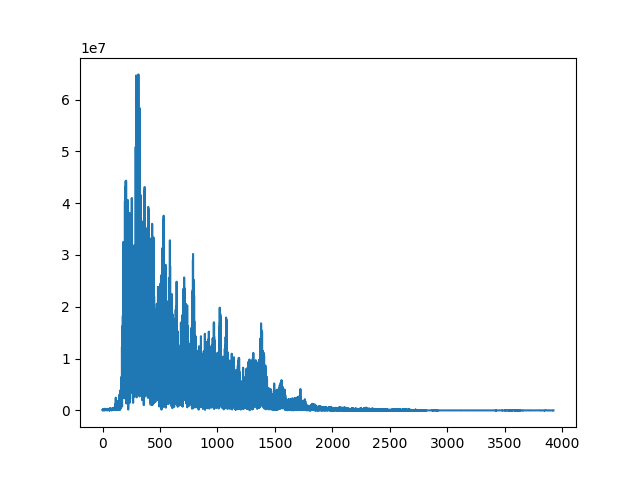

<IPython.core.display.Javascript object>


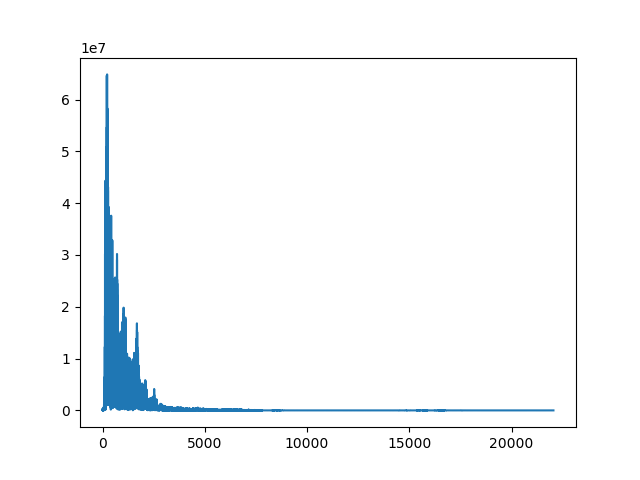

In [15]:
plt.figure(1)
plt.plot(np.abs(a))
plt.figure(2)
plt.plot(mel,np.abs(b))
plt.figure(3)
plt.plot(get_freqs(c), np.abs(b));

<IPython.core.display.Javascript object>


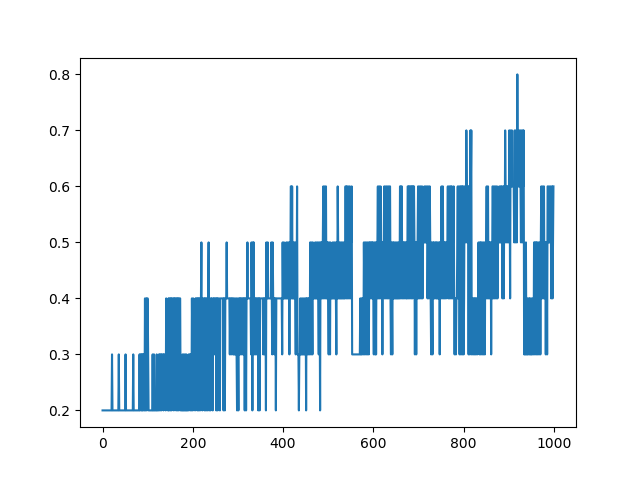

In [8]:
plt.plot(acc)